In [20]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [21]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

In [22]:
# ArmaProcess로 모형 생성하고 nobs만큼 샘플 생성
def gen_arma_samples (ar, ma, nobs):
    arma_model = ArmaProcess(ar=ar, ma=ma)  # 모형 정의
    arma_samples = arma_model.generate_sample(nobs) #샘플 생성
    return arma_samples

In [23]:
# drift가 있는 모형은 ArmaProcess에서 처리가 안 되어서 수동으로 정의 해줘야 함
def gen_random_walk_w_drift(nobs, drift):
    init = np.random.normal(size=nobs, scale=1)
    y = np.zeros(nobs)
    y[0] = init
    for t in (1, nobs):
        y[t] = drift +1 * y[t-1] + e[t]
        return y

In [24]:
np.random.seed(12345)

white_noise = gen_arma_samples(ar = [1], ma=[1], nobs=250)
#y_t = epsilon_t
random_walk = gen_arma_samples(ar=[1, -1], ma = [1], nobs=250)
#(1-L)y_t = epsilon_t
random_walk_w_drift = gen_random_walk_w_drift(250, 2)
# y_t = 2 + y_{t-1} + epsilon_t
stationary_ar_1 = gen_arma_samples(ar = [1, -0.9], ma=[1], nobs=250)
#(1-0.9L)y_t = epsilon_t

ValueError: setting an array element with a sequence.

AttributeError: 'AxesSubplot' object has no attribute 'settitle'

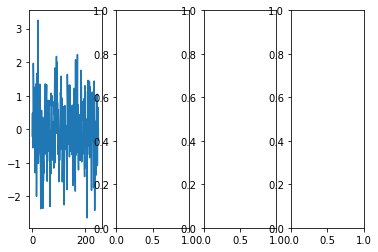

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4)
ax[0].plot(white_noise)
ax[0].settitle("WhiteNoise")

ax[1].plot(random_walk)
ax[1].set_title('Random Walk')

ax[2].plot(random_walk_w_drift)
ax[2].set_title('Random Walk with drift = 3')

ax[3].plot(stationary_ar_1)
ax[3].set_title('Stationart AR(1)')

fig.set_size_inches(16,4)
plt.show()

# auto_arima 모델을 이용한 삼성 주가 예측

In [26]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [28]:
krx = fdr.StockListing('KRX')
krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [31]:
ticker = krx[krx['Name']=='삼성전자']['Symbol']
ticker

4137    005930
Name: Symbol, dtype: object

In [32]:
ss = fdr.DataReader(''.join(ticker.values), start = '2020-01-01', end= '2021-12-21')

<AxesSubplot:xlabel='Date'>

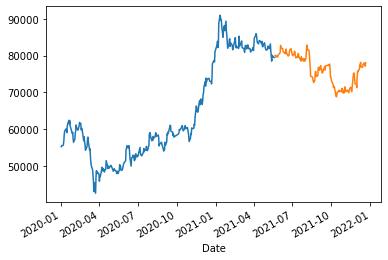

In [36]:
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)) : ] 


y_train.plot()
y_test.plot()

In [37]:
from pmdarima.arima import ndiffs

In [40]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(kpss_diffs, adf_diffs)

print(n_diffs)

1


# auto_arima
* pmdarima.arima.auto_arima
* auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [41]:
from pmdarima.arima import auto_arima

In [42]:
model = auto_arima(y = y_train        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                    #   , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5810.372, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5812.313, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5812.329, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5809.562, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5814.327, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.711 seconds


In [43]:
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [44]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  342
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2903.781
Date:                Mon, 25 Jul 2022   AIC                           5809.562
Time:                        10:52:08   BIC                           5813.394
Sample:                             0   HQIC                          5811.089
                                - 342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.454e+06   7.85e+04     18.522      0.000     1.3e+06    1.61e+06
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                67.84
Prob(Q):                              0.88   Pr

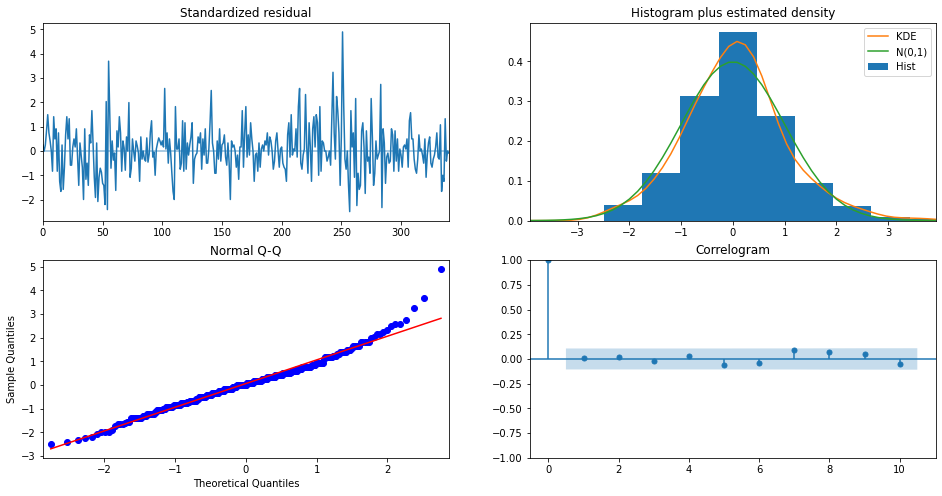

In [45]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

## 예측

In [46]:
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])
y_predict


,Prediction
Date,
2021-05-21,79500.0
2021-05-24,79500.0
2021-05-25,79500.0
2021-05-26,79500.0
2021-05-27,79500.0
...,...
2021-12-15,79500.0
2021-12-16,79500.0
2021-12-17,79500.0


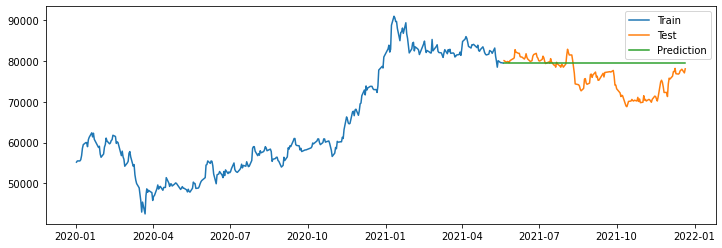

In [47]:
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [48]:
import os

In [49]:
os.getcwd()

'c:\\PYTHON\\G_ML'